In [1]:
import numpy as np
import scipy.stats
import torch

confidence = 0.95

def measure(value, tolerance=0, factor=1, intercept=0):
	"""Measure a value with uncertainty, returning a torch.Tensor with an extra uncertainty attribute."""
	systematic_error = tolerance * confidence	# assuming the data is uniformly distributed within the tolerance

	if isinstance(value, (list, np.ndarray)):
		ME = margin_of_error(np.array(value))
		mean_value = (np.mean(value) - intercept) * factor
		uncertainty = np.sqrt(ME**2 + systematic_error**2) * factor
	else:
		mean_value = (value - intercept) * factor
		uncertainty = systematic_error * factor

	# Create a Tensor object and attach the uncertainty as an attribute
	result_tensor = torch.tensor(mean_value, dtype=torch.float, requires_grad=True)
	setattr(result_tensor, 'uncertainty', uncertainty)

	print(f'Measured Value {mean_value} ± {uncertainty}')
	return result_tensor

def margin_of_error(value):
	"""Calculate Margin of Error (the uncertainty associated with random error), using the t-distribution."""
	return scipy.stats.t.ppf((1 + confidence) / 2, len(value) - 1) * np.std(value, ddof=1) / np.sqrt(len(value))

def uncertainty(result, inputs):
	"""Calculate the uncertainty of a result based on the uncertainties of its inputs."""
	if not all(hasattr(input, 'uncertainty') for input in inputs if isinstance(input, torch.Tensor)):
		raise ValueError("All inputs must have an 'uncertainty' attribute.")

	derivatives = []
	for input in inputs:
		if isinstance(input, torch.Tensor) and hasattr(input, 'uncertainty'):
			input.requires_grad_(True)
			derivative = torch.autograd.grad(outputs=result, inputs=input, retain_graph=True)[0]
			derivatives.append(input.uncertainty * derivative)

	derivatives = torch.tensor(derivatives)
	total_uncertainty = torch.sqrt(torch.sum(derivatives ** 2))
	setattr(result, 'uncertainty', total_uncertainty.item())
	setattr(result, 'contributions', derivatives)

	print(f'Result: {result.item()} ± {total_uncertainty.item()}')
	return result

def relative_uncertainty(value : torch.Tensor):
	"""Calculate the relative uncertainty of a value."""
	if not hasattr(value, 'uncertainty'):
		raise ValueError("The input must have an 'uncertainty' attribute. Call the `uncertainty` function first.")
	return value.uncertainty / value.item()

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Exp 7 : Collisions

## 1 - Measure the density of the ball

In [4]:
# Measurements for the diameter of the ball in cm
diameters = [2.000, 2.000, 2.000, 1.998, 2.000, 2.002]
# Tolerance for the measurement
tolerance_diameter = 0.002

# Measure the diameter
measured_diameter = measure(diameters, tolerance=tolerance_diameter)
print(f"Measured Diameter: {measured_diameter.item()} cm ± {measured_diameter.uncertainty} cm")

# Mass of the ball in grams
mass = 32.603
# Tolerance for the mass measurement
tolerance_mass = 0.001

# Measure the mass
measured_mass = measure(mass, tolerance=tolerance_mass)
print(f"Measured Mass: {measured_mass.item()} g ± {measured_mass.uncertainty} g")

# Calculate the radius from the diameter
radius = measured_diameter / 2
radius = uncertainty(radius, [measured_diameter])
print(f"Radius: {radius.item()} cm ± {radius.uncertainty} cm")

# Calculate the volume of the ball (V = 4/3 * pi * r^3)
volume = 4/3 * np.pi * radius**3
volume = uncertainty(volume, [radius])
print(f"Volume: {volume.item()} cm^3 ± {volume.uncertainty} cm^3")

# Convert mass to kg and volume to m^3 for SI units
mass_kg = measured_mass / 1000
volume_m3 = volume / 1e6

# Calculate the density (ρ = mass / volume)
density = mass_kg / volume_m3
density = uncertainty(density, [mass, volume])
print(f"Density: {density.item()} kg/m^3 ± {density.uncertainty} kg/m^3")

# Calculate relative uncertainties
relative_uncertainty_diameter = relative_uncertainty(measured_diameter)
relative_uncertainty_mass = relative_uncertainty(measured_mass)
relative_uncertainty_radius = relative_uncertainty(radius)
relative_uncertainty_volume = relative_uncertainty(volume)
relative_uncertainty_density = relative_uncertainty(density)

print(f"Relative Uncertainty of Diameter: {relative_uncertainty_diameter * 100:.2f}%")
print(f"Relative Uncertainty of Mass: {relative_uncertainty_mass * 100:.2f}%")
print(f"Relative Uncertainty of Radius: {relative_uncertainty_radius * 100:.2f}%")
print(f"Relative Uncertainty of Volume: {relative_uncertainty_volume * 100:.2f}%")
print(f"Relative Uncertainty of Density: {relative_uncertainty_density * 100:.2f}%")

Measured Value 2.0 ± 0.0023177800286039735
Measured Diameter: 2.0 cm ± 0.0023177800286039735 cm
Measured Value 32.603 ± 0.00095
Measured Mass: 32.60300064086914 g ± 0.00095 g
Result: 1.0 ± 0.0011588899651542306
Radius: 1.0 cm ± 0.0011588899651542306 cm
Result: 4.188790321350098 ± 0.014563040807843208
Volume: 4.188790321350098 cm^3 ± 0.014563040807843208 cm^3
Result: 7783.39306640625 ± 27.060287475585938
Density: 7783.39306640625 kg/m^3 ± 27.060287475585938 kg/m^3
Relative Uncertainty of Diameter: 0.12%
Relative Uncertainty of Mass: 0.00%
Relative Uncertainty of Radius: 0.12%
Relative Uncertainty of Volume: 0.35%
Relative Uncertainty of Density: 0.35%


## 2 - x-$\Delta E$

In [13]:
h_cm = np.array([3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0, 13.0, 15.0])
x_cm = np.array([7.7, 10.4, 11.9, 13.4, 16.0, 17.7, 19.1, 19.4, 21.5, 23.4])
y_cm = 15.72
m_1 = float(measured_mass) / 1000
g = 9.794
delta_e = m_1 * g * (h_cm - (x_cm * x_cm) / (4 * y_cm)) / 100

In [16]:
pd.DataFrame({'x (cm)': x_cm, 'h (cm)': h_cm, 'delta_e (mJ)': delta_e * 1000})

,x (cm),h (cm),delta_e (mJ)
0,7.7,3.0,6.568581
1,10.4,4.0,7.280029
2,11.9,5.0,8.774528
3,13.4,6.0,10.040509
4,16.0,8.0,12.545051
5,17.7,9.0,12.828919
6,19.1,10.0,13.405796
7,19.4,11.0,16.012408
8,21.5,13.0,18.037065
9,23.4,15.0,20.091175


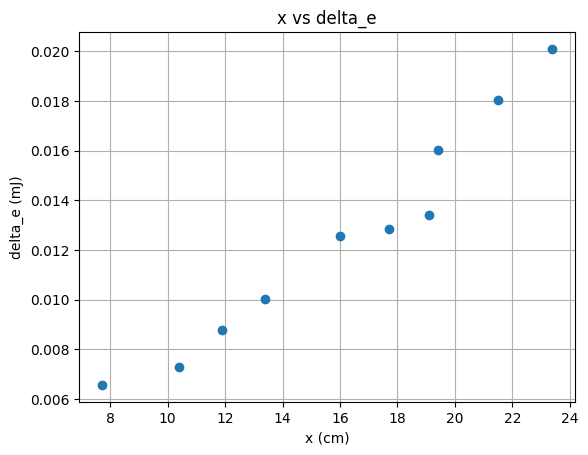

In [17]:
# plot x vs delta_e
plt.figure()
plt.plot(x_cm, delta_e, 'o')
plt.xlabel('x (cm)')
plt.ylabel('delta_e (mJ)')
plt.title('x vs delta_e')
plt.grid()
plt.show()

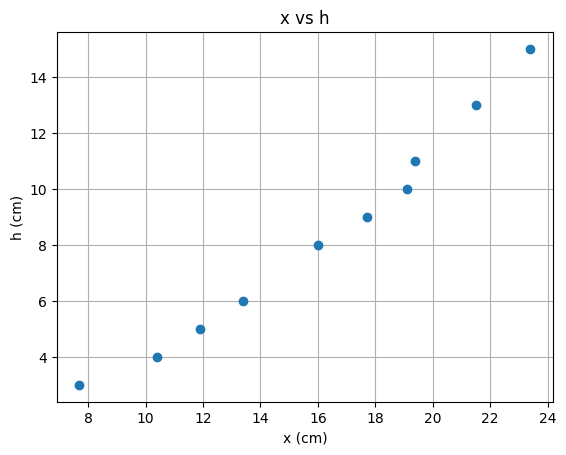

In [18]:
## plot x vs h
plt.figure()
plt.plot(x_cm, h_cm, 'o')
plt.xlabel('x (cm)')
plt.ylabel('h (cm)')
plt.title('x vs h')
plt.grid()
plt.show()

## 3 - material - $\Delta E$

In [24]:
import pandas as pd

# Constants
x = 11.9  # cm
y = 15.72  # cm
m_1 = 32.603  # g
g = 9.794  # m/s²

# Densities (g/cm³)
densities = {
    "copper": 8.96,
    "steel": 7.78,
    "aluminum": 2.70
}

# Heights (cm)
h_values = [5.5, 5.0, 2.5]

# Calculation of h_0 and delta_e
results = []

for material, density, h in zip(densities.keys(), densities.values(), h_values):
	rho_2 = density
	rho_1 = densities["steel"]
	h_0 = (rho_1 + rho_2)**2 * x**2 / (16 * rho_1**2 * y)
	delta_e = m_1 / 1000 * g * (h - h_0) / 100
	results.append([material, density, h, h_0, delta_e * 1000])


# Creating DataFrame
columns = ["Material", "Density (g/cm³)", "h (cm)", "h_0 (cm)", "delta_e (mJ)"]
df = pd.DataFrame(results, columns=columns)

df

,Material,Density (g/cm³),h (cm),h_0 (cm),delta_e (mJ)
0,copper,8.96,5.5,2.606592,9.239049
1,steel,7.78,5.0,2.252067,8.774527
2,aluminum,2.70,2.5,1.021609,4.720706
